# Task 3: Helper notebook for loading the data and saving the predictions

In [1]:
import pickle
import gzip
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import cv2

### Helper functions

In [2]:
def load_zipped_pickle(filename):
    with gzip.open(filename, 'rb') as f:
        loaded_object = pickle.load(f)
        return loaded_object

In [3]:
def save_zipped_pickle(obj, filename):
    with gzip.open(filename, 'wb') as f:
        pickle.dump(obj, f, 2)

### Load data, make predictions and save prediction in correct format

In [4]:
# load data
train_data = load_zipped_pickle("train.pkl")
test_data = load_zipped_pickle("test.pkl")
samples = load_zipped_pickle("sample.pkl")

In [30]:
IMG_SIZE = max(max(set(d['box'].shape[0] for d in train_data)), max(set(d['box'].shape[1] for d in train_data))) //64*64 // 8

IMG_SIZE = (IMG_SIZE, IMG_SIZE)
print(IMG_SIZE)

(104, 104)


In [31]:
shapes = []

for d in train_data:
    shapes.append(d['video'].shape)

shapes_np = np.array(shapes)

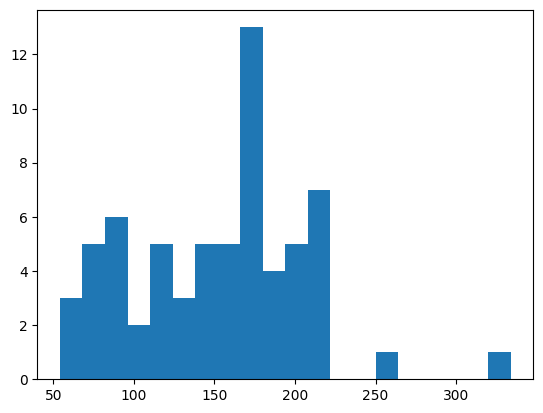

In [32]:
plt.hist(shapes_np[:,2], bins=20);

In [33]:
sorted(shapes_np[:,2])[-5:]

[215, 216, 221, 258, 334]

In [34]:
length = sorted(shapes_np[:,2])[-2]
length

258

In [35]:
box = cv2.resize(train_data[0]['box'].astype('float64'), IMG_SIZE, interpolation = cv2.INTER_LANCZOS4).astype('bool')

(62, 94, 43, 91)
0


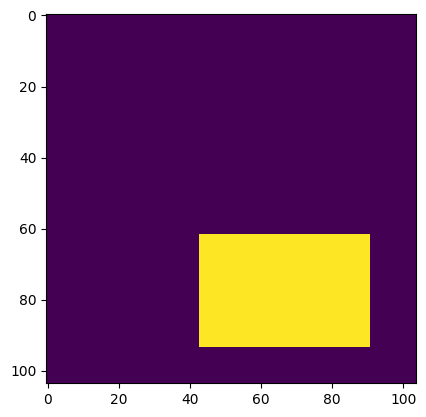

In [36]:
a = (
    box.any(axis=1).argmax(axis=0),
    box.shape[0]-box[::-1].any(axis=1).argmax(axis=0),
    box.any(axis=0).argmax(axis=0),
    box.shape[1]-box[:,::-1].any(axis=0).argmax(axis=0)
    )

print(a)

b = np.zeros_like(box)
b[ a[0]:a[1], a[2]:a[3]] = 1

print((~(box == b)).sum())

plt.imshow(box);


In [37]:
lower_clip = 15
upper_clip = 230

video_dict = {}
box_dict = {}
name_to_id = {}
id_to_name = {}

def get_box_bounds(box):
    return (
            box.any(axis=1).argmax(axis=0),
            box.shape[0]-box[::-1].any(axis=1).argmax(axis=0),
            box.any(axis=0).argmax(axis=0),
            box.shape[1]-box[:,::-1].any(axis=0).argmax(axis=0)
            )

for i, d in enumerate(train_data):
    name_to_id[d['name']] = i
    id_to_name[i] = d['name']
    
    video_gray = cv2.resize(d['video'].astype('float64'), IMG_SIZE, interpolation = cv2.INTER_LANCZOS4)
    video_gray = np.clip(video_gray, lower_clip, upper_clip) - lower_clip
    video_gray /= video_gray.max(axis=(0,1), keepdims=True)
    video_gray **= 1.2
    video_gray = np.tile(video_gray, [1,1, (length // video_gray.shape[2]) + 1])[:,:,:length]
    video_gray = video_gray.transpose(2,0,1)
    video_gray = video_gray.reshape(*video_gray.shape, 1)

    video_dict[i] = video_gray


    box = cv2.resize(d['box'].astype('float64'), IMG_SIZE, interpolation = cv2.INTER_LANCZOS4).astype('bool')
    box_dict[i] = get_box_bounds(box)
    
video_np = np.array([video_dict[i] for i in range(len(video_dict))])
box_np = np.array([box_dict[i] for i in range(len(box_dict))])

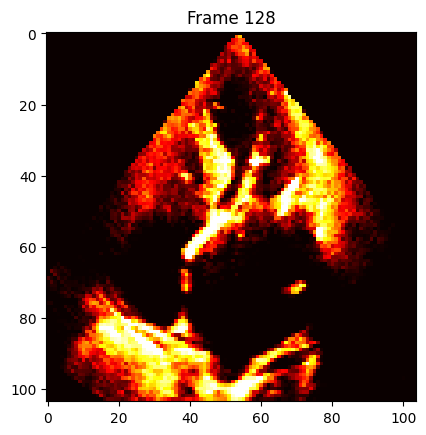

In [38]:
from IPython.display import clear_output

index =  -7
sleep_time = 0

plt.figure()
for i in range(length // 2):
    
    image = video_np[index,i,:,:,0]
    plt.imshow(image, cmap='hot')
    plt.title('Frame %d' % i)
    plt.show()
    clear_output(wait=True)
    plt.pause(sleep_time)

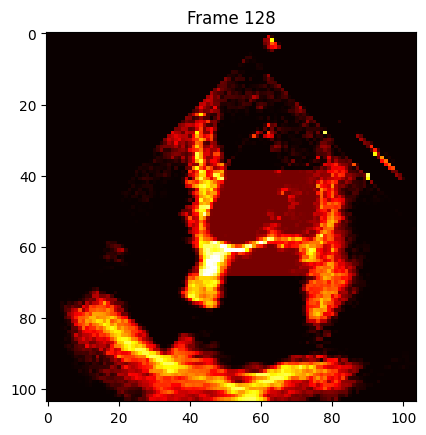

In [39]:
index =  4
sleep_time = 0

plt.figure()
for i in range(length // 2):

    box = np.zeros_like(video_np[index,i,:,:,0])
    box[box_np[index,0]:box_np[index,1], box_np[index,2]:box_np[index,3]] = 1
    
    image = video_np[index,i,:,:,0] + box/5
    plt.imshow(image, cmap='hot')
    plt.title('Frame %d' % i)
    plt.show()
    clear_output(wait=True)
    plt.pause(sleep_time)

In [40]:
video_np.shape, box_np.shape, video_np.max(), video_np.min()

((65, 258, 104, 104, 1), (65, 4), 1.0, 0.0)

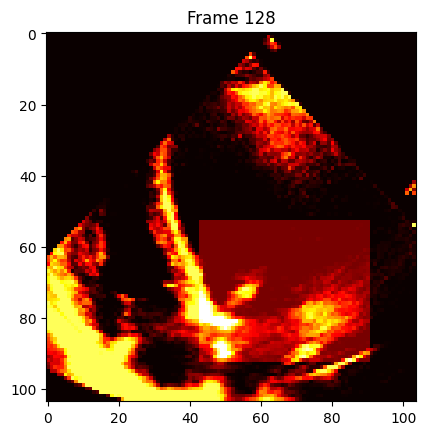

In [41]:
index =  1
sleep_time = 0

plt.figure()
for i in range(length // 2):

    box = np.zeros_like(video_np[index,i,:,:,0])
    box[box_np[index,0]:box_np[index,1], box_np[index,2]:box_np[index,3]] = 1
    
    image = video_np[index,i,:,:,0] + box/5
    plt.imshow(image, cmap='hot')
    plt.title('Frame %d' % i)
    plt.show()
    clear_output(wait=True)
    plt.pause(sleep_time)

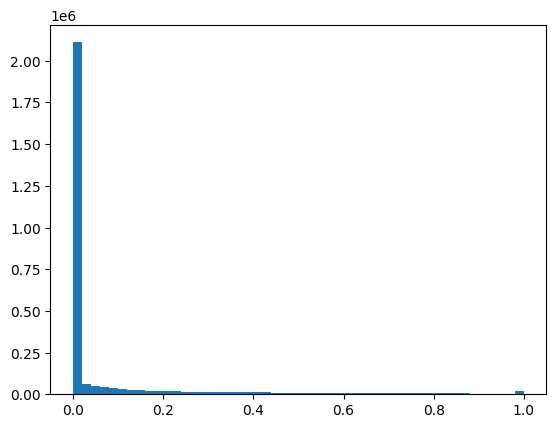

In [42]:
plt.hist(video_np[-1].flatten(), bins=50);

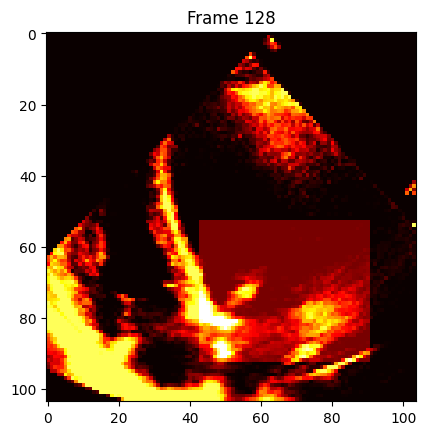

In [43]:
index =  1
sleep_time = 0

plt.figure()
for i in range(length // 2):

    box = np.zeros_like(video_np[index,i,:,:,0])
    box[box_np[index,0]:box_np[index,1], box_np[index,2]:box_np[index,3]] = 1
    
    image = video_np[index,i,:,:,0] + box/5
    plt.imshow(image, cmap='hot')
    plt.title('Frame %d' % i)
    plt.show()
    clear_output(wait=True)
    plt.pause(sleep_time)

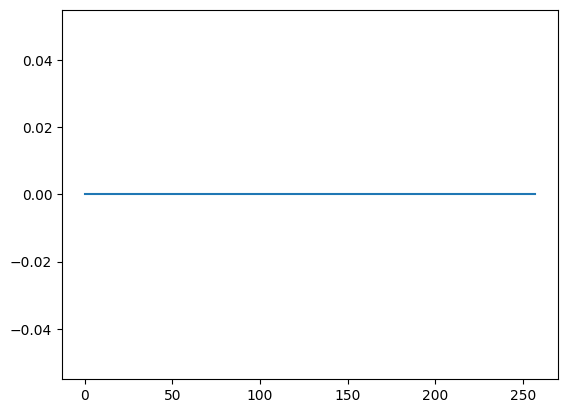

In [44]:
plt.figure()
plt.plot([video_np[index,i,:20,:20,0].sum() for i in range(length)])

In [45]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers

In [75]:
X_train = video_np

y_train = (box_np / IMG_SIZE[0] - 0.5)*2

In [47]:
y_train.max(axis=0), y_train.min(axis=0)

(array([0.28846154, 0.90384615, 0.09615385, 0.94230769]),
 array([-0.46153846,  0.03846154, -0.38461538,  0.19230769]))

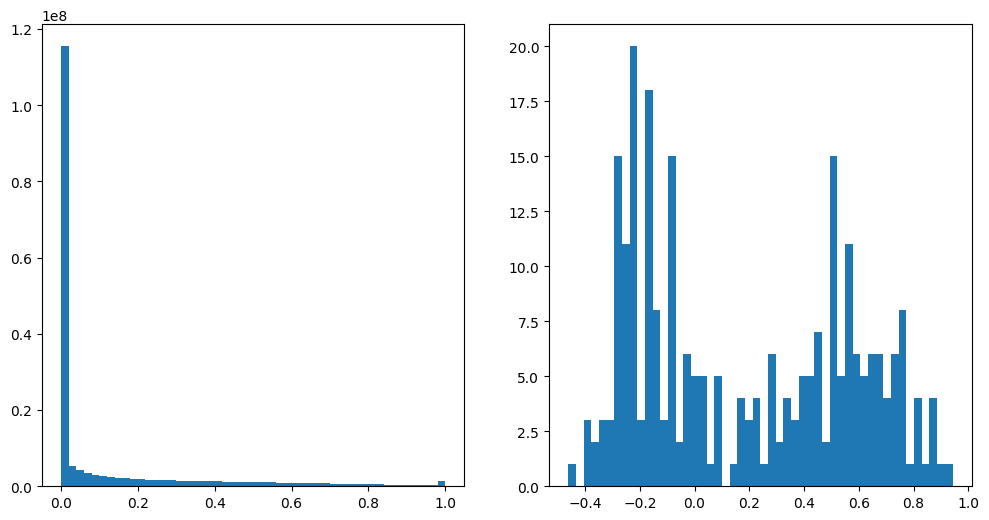

In [48]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.hist(X_train.flatten(), bins=50);
plt.subplot(1,2,2)
plt.hist(y_train.flatten(), bins=50);

In [76]:
X_train.shape, y_train.shape

((65, 258, 104, 104, 1), (65, 4))

In [77]:
X_train = X_train.reshape(-1, *X_train.shape[2:])
X_train.shape

(16770, 104, 104, 1)

In [79]:
y_train = np.repeat(y_train, 258, axis=0)
y_train.shape

(16770, 4)

In [82]:
seed = 1

In [87]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=seed)

# MODEL

In [88]:
dropout = .3

In [89]:
def double_conv_block(x, n_filters):

   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "linear", kernel_initializer = "he_normal")(x)
   x = layers.BatchNormalization()(x)
   x = layers.Activation("relu")(x)
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

   return x

In [90]:
def downsample_block(x, n_filters):
   
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2, strides=2)(f)
   p = layers.BatchNormalization()(p)
   p = layers.Dropout(dropout)(p)

   return f, p

In [91]:
def upsample_block(x, conv_features, n_filters):
   
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same", activation="linear")(x)
   x = layers.BatchNormalization()(x)
   x = layers.Activation("relu")(x)
   x = layers.concatenate([x, conv_features])
   x = layers.Dropout(dropout)(x)
   x = double_conv_block(x, n_filters)

   return x

In [166]:
def build_boxing_model():
    
    inputs = layers.Input(shape=IMG_SIZE + (1,))

    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 128)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 256)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 512)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 1024)

    p5 = keras.layers.GlobalAveragePooling2D()(p4)

    x = layers.Dense(256, activation='linear')(p5)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(dropout)(x)
    # outputs
    outputs = layers.Dense(4, activation='sigmoid')(x)

    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

boxing_model = build_boxing_model()

In [167]:
print(boxing_model.summary())

Model: "U-Net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 104, 104, 1)]     0         
                                                                 
 conv2d_93 (Conv2D)          (None, 104, 104, 128)     1280      
                                                                 
 batch_normalization_90 (Ba  (None, 104, 104, 128)     512       
 tchNormalization)                                               
                                                                 
 activation_46 (Activation)  (None, 104, 104, 128)     0         
                                                                 
 conv2d_94 (Conv2D)          (None, 104, 104, 128)     147584    
                                                                 
 max_pooling2d_44 (MaxPooli  (None, 52, 52, 128)       0         
 ng2D)                                                       

In [168]:
# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
keras.utils.set_random_seed(seed)

In [169]:
def scheduler(epoch, lr):
    if epoch>0 and epoch % 7 == 0:
        return lr / 10
    else:
        return lr

callback = keras.callbacks.LearningRateScheduler(scheduler)

In [170]:
boxing_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(),
                  loss="mse",
                  metrics=["mae", "mape"])#, keras.metrics.MeanIoU(num_classes=2)])

NUM_EPOCHS = 20

model_history = boxing_model.fit(X_train,
                                    y_train,
                                    batch_size=512,
                                    epochs=NUM_EPOCHS,
                                    callbacks=[callback],
                                    validation_data=(X_test, y_test))

Epoch 1/20
30/30 [==============================] - 98s 3s/step - loss: 0.1477 - mae: 0.2767 - mape: 6892459.0000 - val_loss: 0.4402 - val_mae: 0.5364 - val_mape: 9392110.0000 - lr: 0.0010
Epoch 2/20
30/30 [==============================] - 95s 3s/step - loss: 0.0404 - mae: 0.1523 - mape: 1443247.2500 - val_loss: 0.1351 - val_mae: 0.3147 - val_mape: 132721.0312 - lr: 0.0010
Epoch 3/20
30/30 [==============================] - 96s 3s/step - loss: 0.0335 - mae: 0.1383 - mape: 918399.7500 - val_loss: 0.1357 - val_mae: 0.3060 - val_mape: 4076801.2500 - lr: 0.0010
Epoch 4/20
30/30 [==============================] - 96s 3s/step - loss: 0.0279 - mae: 0.1282 - mape: 859329.1875 - val_loss: 0.0663 - val_mae: 0.2117 - val_mape: 76432.0312 - lr: 0.0010
Epoch 5/20
30/30 [==============================] - 101s 3s/step - loss: 0.0252 - mae: 0.1194 - mape: 656166.7500 - val_loss: 0.0514 - val_mae: 0.1929 - val_mape: 122938.0547 - lr: 0.0010
Epoch 6/20
30/30 [==============================] - 102s 3s/s

In [135]:
boxing_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(),
                  loss="mse",
                  metrics=["mae", "mape"])#, keras.metrics.MeanIoU(num_classes=2)])

NUM_EPOCHS = 20

model_history = boxing_model.fit(X_train,
                                    y_train,
                                    batch_size=512,
                                    epochs=NUM_EPOCHS,
                                    callbacks=[callback],
                                    validation_data=(X_test, y_test))

Epoch 1/50
30/30 [==============================] - 31s 1s/step - loss: 0.1743 - mae: 0.3277 - mape: 8952028.0000 - val_loss: 0.1066 - val_mae: 0.2830 - val_mape: 5887687.5000 - lr: 0.0010
Epoch 2/50
30/30 [==============================] - 28s 930ms/step - loss: 0.0438 - mae: 0.1591 - mape: 2844574.2500 - val_loss: 0.0532 - val_mae: 0.2015 - val_mape: 1447138.2500 - lr: 0.0010
Epoch 3/50
30/30 [==============================] - 28s 928ms/step - loss: 0.0246 - mae: 0.1142 - mape: 974987.5000 - val_loss: 0.0443 - val_mae: 0.1793 - val_mape: 1171130.0000 - lr: 0.0010
Epoch 4/50
30/30 [==============================] - 28s 927ms/step - loss: 0.0226 - mae: 0.1066 - mape: 655117.6250 - val_loss: 0.0530 - val_mae: 0.1945 - val_mape: 723102.4375 - lr: 0.0010
Epoch 5/50
30/30 [==============================] - 28s 930ms/step - loss: 0.0221 - mae: 0.1039 - mape: 527284.6875 - val_loss: 0.0475 - val_mae: 0.1805 - val_mape: 562956.1875 - lr: 0.0010
Epoch 6/50
30/30 [==============================

KeyboardInterrupt: 

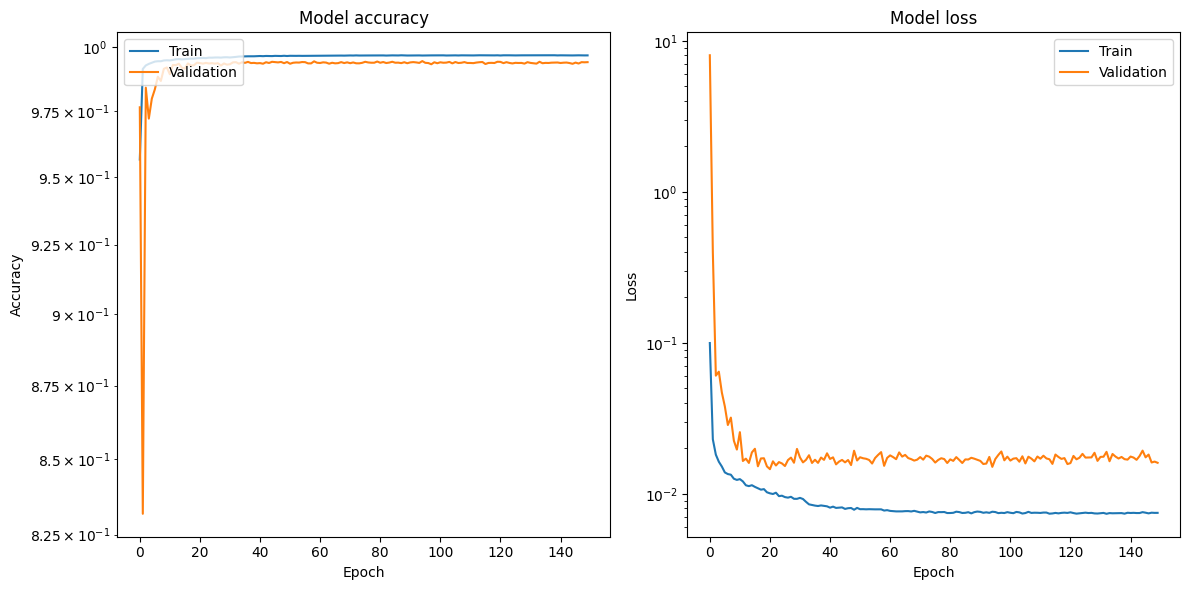

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(model_history.history['mae'])
plt.plot(model_history.history['val_mae'])
plt.yscale('log')
plt.title('Model accuracy')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.yscale('log')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()

In [152]:
y_pred = ((boxing_model.predict(X_test) + 1) / 2 * IMG_SIZE[0]).astype('int')

53/53 [==============================] - 1s 16ms/step


In [153]:
y_pred[0], y_test.shape

(array([54, 69, 61, 84]), (1677, 4))

In [154]:
((y_test[0]+ 1) / 2 * IMG_SIZE[0]).astype('int')

array([41, 76, 39, 89])

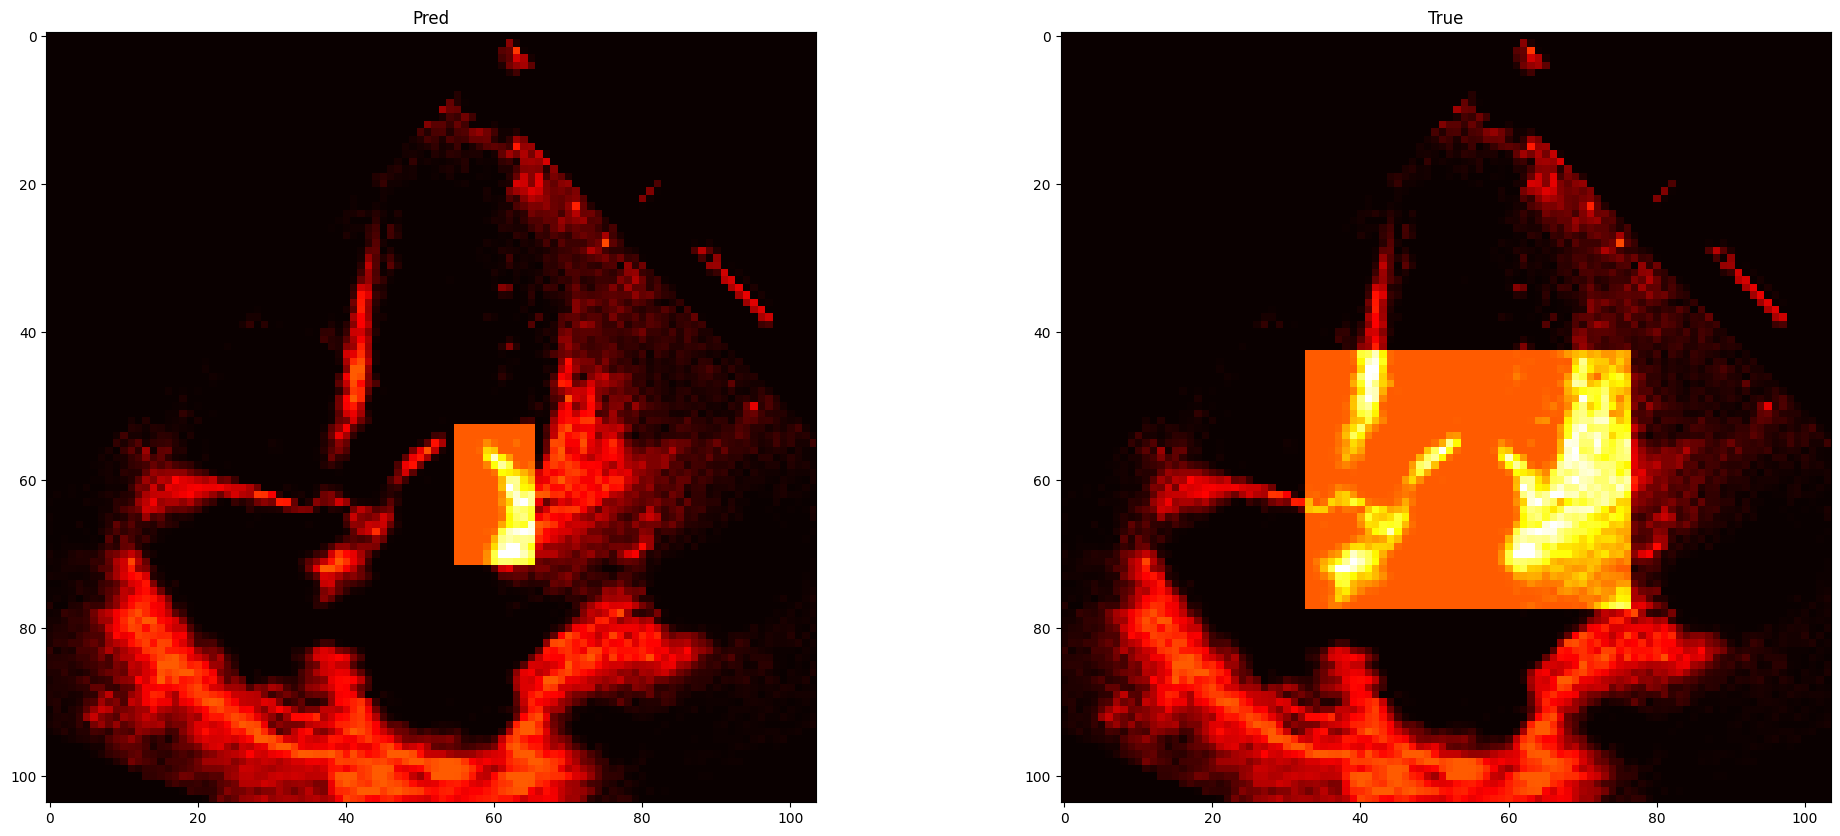

In [171]:
import time
# X_train = X_train.reshape(65, 258, *IMG_SIZE)

for i in range(300):
    plt.figure(figsize=(24, 10))
    plt.subplot(1, 2, 1)
    a = y_pred[i]
    box = np.zeros_like(X_test[i])
    box[ a[0]:a[1], a[2]:a[3]] = 1
    plt.title('Pred')
    plt.imshow(X_test[i] +box, cmap='hot')
    plt.subplot(1, 2, 2)
    a = ((y_test[i]+ 1) / 2 * IMG_SIZE[0]).astype('int')
    box = np.zeros_like(X_test[i])
    box[ a[0]:a[1], a[2]:a[3]] = 1
    plt.title('True')
    plt.imshow(X_test[i] + box, cmap='hot')
    plt.show()
    clear_output(wait=True)
    time.sleep(.5)

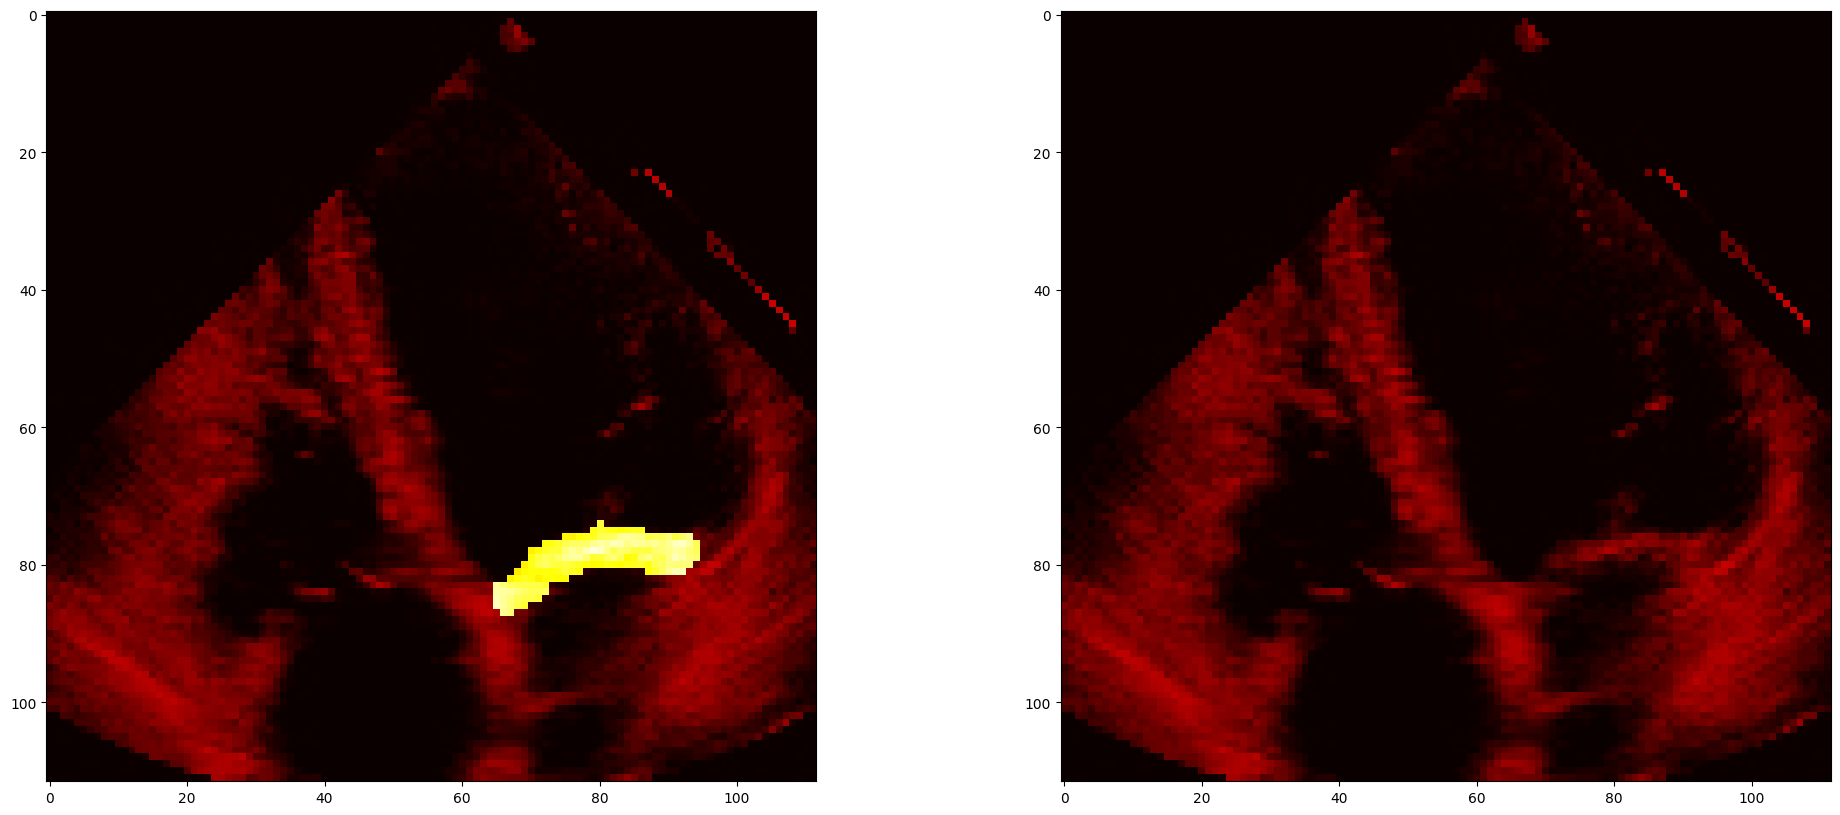

In [ ]:
a = next(test_generator)
b = np.where(unet_model.predict(a)>0.5, 1, 0)

for i in range(batch_size):
    plt.figure(figsize=(24, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(a[i] + 5*b[i], cmap='hot', vmin=-1, vmax=6)
    plt.subplot(1, 2, 2)
    plt.imshow(a[i], cmap='hot', vmin=-1, vmax=6)
    plt.show()
    clear_output(wait=True)
    time.sleep(1)

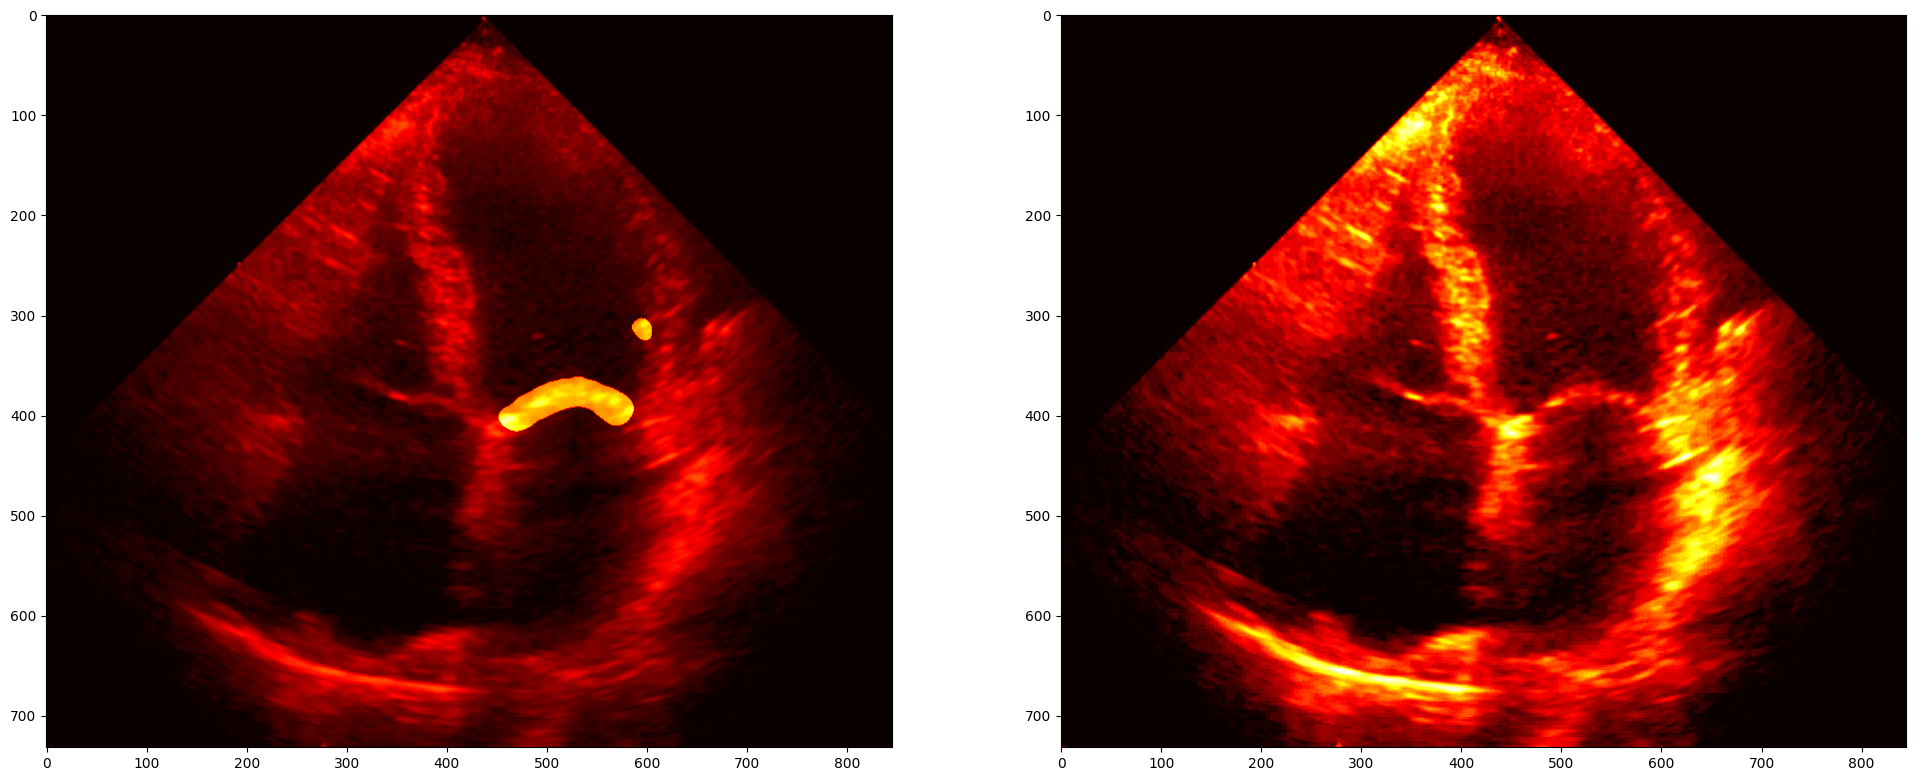

In [ ]:
ind = 4

video = test_data[ind]['video']

video_gray = cv2.resize(video, IMG_SIZE, interpolation = cv2.INTER_LANCZOS4).astype(np.uint8)
video_gray = preprocessing_function(video_gray).transpose(2,0,1)
video_gray = video_gray.reshape(*video_gray.shape, 1)

predictions = unet_model.predict(video_gray, verbose=False).transpose(1,2,0,3)[:,:,:,0]
predictions = cv2.resize(predictions, (video.shape[1], video.shape[0]), interpolation = cv2.INTER_LANCZOS4)
predictions = np.where(predictions>.5, True, False)

for i in range(predictions.shape[2]):
    plt.figure(figsize=(24, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(video[:,:,i]/255 + predictions[:,:,i].astype(bool), cmap='hot', vmin=0, vmax=2)
    plt.subplot(1, 2, 2)
    plt.imshow(video[:,:,i]/255, cmap='hot', vmin=0, vmax=1)
    plt.show()
    clear_output(wait=True)
    # time.sleep(.01)

In [ ]:
predictions_list = []

for d in test_data:

    video = d['video']

    video_gray = cv2.resize(video, IMG_SIZE, interpolation = cv2.INTER_LANCZOS4).astype(np.uint8)
    video_gray = preprocessing_function(video_gray).transpose(2,0,1)
    video_gray = video_gray.reshape(*video_gray.shape, 1)

    predictions = unet_model.predict(video_gray, verbose=False).transpose(1,2,0,3)[:,:,:,0]
    predictions = cv2.resize(predictions, (video.shape[1], video.shape[0]), interpolation = cv2.INTER_LANCZOS4)
    predictions = np.where(predictions>.5, True, False)

    predictions_list.append({
        'name': d['name'],
        'prediction': predictions
        }
    )

In [ ]:
save_zipped_pickle(predictions_list, 'my_predictions.pkl')